# Question 3 : Dimensionality Reduction

# 1) Dimension Reduction on Question 1

## Dimensionality Reduction using AutoEncoders

In [63]:
import numpy as np
import pandas as pd
import keras
import torch.nn as nn
import torch
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [37]:
Data_set = pd.read_csv('/content/ionosphere.data',header=None)
Data_set['y'] = Data_set[34]
Data_set = Data_set.drop(34,axis = 1)
Data_set[0] = Data_set[0].astype('category')
Data_set['y'] = Data_set['y'].astype('category')
Data_set['y'] = Data_set['y'].replace({'g':1, 'b' : 0})

In [38]:
input = Data_set.drop('y',axis = 1).to_numpy()
output = Data_set['y'].to_numpy()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42, stratify=output)

In [40]:
scale_train = minmax_scale(X_train, axis = 0)
scale_test = minmax_scale(X_test, axis = 0)

### Defining the AutoEncoder

In [41]:
encoding = 17
n = 34
dim = Input(shape = (n, ))

# Encoder Layers
encoder_1 = Dense(28, activation = 'relu')(dim)
encoder_2 = Dense(22, activation = 'relu')(encoder_1)
encoder_3 = Dense(encoding, activation = 'relu')(encoder_2)

# Decoder Layers
decoder_1 = Dense(22, activation = 'relu')(encoder_3)
decoder_2 = Dense(28, activation = 'relu')(decoder_1)
decoder_3 = Dense(ncol, activation = 'sigmoid')(decoder_2)

auto_encoder = Model(inputs = dim, outputs = decoder_3)

auto_encoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [42]:
auto_encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_8 (Dense)             (None, 28)                980       
                                                                 
 dense_9 (Dense)             (None, 22)                638       
                                                                 
 dense_10 (Dense)            (None, 17)                391       
                                                                 
 dense_11 (Dense)            (None, 22)                396       
                                                                 
 dense_12 (Dense)            (None, 28)                644       
                                                                 
 dense_13 (Dense)            (None, 34)                986 

### Training the AutoEncoder

In [ ]:
auto_encoder.fit(scale_train, scale_train, epochs = 200, batch_size = 32, shuffle = False, validation_data = (scale_test, scale_test))

### Use AutoEncoder to reduce dimension of train and test data

In [44]:
encoder = Model(inputs = dim, outputs = encoder_3)
encoder_input = Input(shape = (encoding, ))

In [45]:
train_encoder = pd.DataFrame(encoder.predict(scale_train))
train_encoder = train_encoder.add_prefix('feature_')
train_encoder = train_encoder.values

test_encoder = pd.DataFrame(encoder.predict(scale_test))
test_encoder = test_encoder.add_prefix('feature_')
test_encoder = test_encoder.values

train_encoder = train_encoder.astype(np.float)
test_encoder = test_encoder.astype(np.float)

3/3 [==============================] - 0s 3ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [46]:
train_encoder

array([[3.15770888, 5.97711563, 2.69410682, ..., 2.74288893, 5.69406891,
        3.3052361 ],
       [1.9111594 , 5.01259089, 2.46880245, ..., 2.89449859, 4.99127722,
        3.10746217],
       [1.44245362, 4.33601046, 2.45353174, ..., 2.84478116, 4.88710213,
        3.28663468],
       ...,
       [1.13184738, 3.25324345, 0.        , ..., 2.71315527, 0.        ,
        1.37908959],
       [0.6404407 , 4.89365578, 2.02144909, ..., 3.04898095, 3.27196002,
        2.45148087],
       [1.57906115, 4.11474895, 2.47460341, ..., 1.17238224, 3.98824787,
        1.58423114]])

### Trying the encoded training set on the model

In [47]:
class train_model(nn.Module):
    def __init__(self, n_cont, output_size, layers, p=0.5, activation_function = nn.ReLU(inplace=True),
                drop_able = False, batch_normalize = False) :
        super().__init__()
        self.batch_normalize = batch_normalize
        if batch_normalize :
            self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layer = []
        input_n = n_cont
        if len(layers) == 0 :
            layer.append(nn.Linear(input_n,output_size))
            if activation_function != None :
                layer.append(activation_function)
            if drop_able == True :
                layer.append(nn.Dropout(p))
        else :
            for i in layers:
                layer.append(nn.Linear(input_n,i)) 
                if activation_function != None :
                    layer.append(activation_function)
                if batch_normalize :
                    layer.append(nn.BatchNorm1d(i))
                if drop_able == True :
                    layer.append(nn.Dropout(p))
                input_n = i
            layer.append(nn.Linear(layers[-1],output_size))
            
        self.layers = nn.Sequential(*layer)
    
    def forward(self, x_1):
        if self.batch_normalize :
            x_1 = self.bn_cont(x_1)
        x = self.layers(x_1)
        return x

In [48]:
def minibatch(target_x,validation_x,y_t,validation_y, epochs, batch_size,model,criterion,optimizer):
    train_loss_1 = []
    test_loss_1 = []

    tensor_x = torch.tensor(target_x, dtype=torch.float)
    tensor_validation = torch.tensor(validation_x, dtype=torch.float)

    y_t_tensor = torch.tensor(y_t).flatten()
    tensort_validation_y = torch.tensor(validation_y).flatten()

    for i in range(epochs):
        i += 1
        with torch.no_grad():
            y_test = model(tensor_validation)
            test_loss = criterion(y_test, tensort_validation_y)
            test_loss_1.append(test_loss.item())

        start = 0
        while start < len(target_x) :
            if start + batch_size >= len(target_x) :
                prediction_y = model(tensor_x[start:])
                loss = criterion(prediction_y, y_t_tensor[start:start+batch_size])
                train_loss_1.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                break
            else :
                prediction_y = model(tensor_x[start:start+batch_size])
                loss = criterion(prediction_y, y_t_tensor[start:start+batch_size])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                start = start+batch_size


        if i%5 == 1:
            print(f'Epoch: {i:3}  Training Loss: {loss.item():10.8f} Test Loss: {test_loss}')

    print(f'Epoch: {epochs}  Training Loss: {loss.item():10.8f} Test Loss: {test_loss}')

    return train_loss_1,test_loss_1


In [57]:
input_features = encoding
output_features = 2
hidden_layers = [1000, 500, 250, 125]
batch_size = 8
epochs = 30

tr = train_model(input_features, output_features, hidden_layers, p=0.4, activation_function = nn.ReLU(inplace = True),drop_able = True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(tr.parameters(), lr=0.001)

In [60]:
def diagrams(train_loss_1,valid_loss_1,model,target_x,target_y) :
    
    plt.plot(train_loss_1)
    plt.plot(valid_loss_1)
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    tensor_validation = torch.tensor(target_x, dtype=torch.float)
    with torch.no_grad():
        prediction_y = model(tensor_validation)

    validation_y = []

    for i in range(len(prediction_y)):
        validation_y.append(prediction_y[i].argmax().item())

    Confusion_Matrix = confusion_matrix(target_y.tolist(), validation_y)
    sns.heatmap(Confusion_Matrix, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    
    print(classification_report(target_y.tolist(), validation_y, target_names=['bad','good']))

In [61]:
train_loss_1,valid_loss_1 = minibatch(train_encoder,test_encoder, y_train,y_test,epochs, batch_size,tr,criterion,optimizer)

Epoch:   1  Training Loss: 0.15875575 Test Loss: 0.24041607975959778
Epoch:   6  Training Loss: 0.25172350 Test Loss: 0.17749878764152527
Epoch:  11  Training Loss: 0.12059532 Test Loss: 0.14629223942756653
Epoch:  16  Training Loss: 0.16256621 Test Loss: 0.16186870634555817
Epoch:  21  Training Loss: 0.17519017 Test Loss: 0.22012579441070557
Epoch:  26  Training Loss: 0.07861152 Test Loss: 0.1774006485939026
Epoch: 30  Training Loss: 0.16283317 Test Loss: 0.14791744947433472


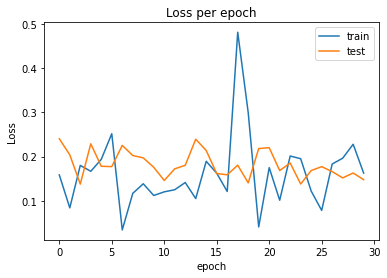

              precision    recall  f1-score   support

         bad       0.88      0.92      0.90        25
        good       0.96      0.93      0.95        46

    accuracy                           0.93        71
   macro avg       0.92      0.93      0.92        71
weighted avg       0.93      0.93      0.93        71



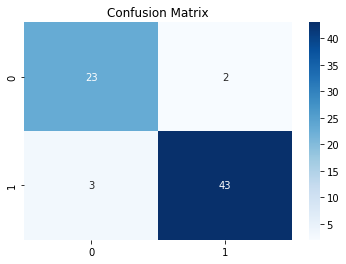

In [62]:
diagrams(train_loss_1,valid_loss_1,tr,test_encoder,y_test)

### The effect of dimension reduction on the model's result
In question 1, we achieved 96% precision but with dimension reduction the precision is 88%. The performance of the model became worse due to possible <b>data loss</b> from dimension reduction.

## Dimensionality Reduction using PCA

In [65]:
scale_x = StandardScaler().fit_transform(input)
scale_x[1]

array([ 0.34843328,  0.        ,  0.72164805, -0.52781074,  0.63430773,
       -1.03758697, -1.33910577, -2.02945199,  0.96407416, -0.46948184,
        0.05785987, -1.68478062, -0.09090821, -1.599628  , -1.32077439,
       -2.28587042, -0.52979769, -1.24735087, -0.04525228, -1.88290035,
       -0.76886206, -0.8915184 , -0.90069558, -0.56945458, -1.03778979,
       -0.38305389, -1.44784862, -0.20841918, -0.9891848 , -0.17352964,
       -0.90906286, -0.11521328, -0.93260505, -0.08328554])

### Covariance matrix


In [66]:
features = scale_x.T
Coavariance_Matrix = np.cov(features)
Coavariance_Matrix[3]

array([-6.54750578e-03,  0.00000000e+00,  1.43774417e-01,  1.00285714e+00,
        1.15514103e-03, -1.90851343e-01, -5.41838976e-02,  2.55731541e-01,
       -3.03180852e-01,  2.08290745e-01, -1.90632900e-01,  3.16779785e-01,
       -1.49642618e-01,  2.37280420e-01, -2.53872855e-01,  1.86403368e-01,
       -2.51860511e-01, -1.47872635e-01, -3.33162250e-01,  1.67721934e-01,
       -2.81886795e-01, -3.55018389e-02, -1.44129607e-01,  1.64665149e-01,
       -1.04930880e-01, -2.37664211e-01, -4.70435699e-02,  7.45165168e-04,
       -4.12078088e-02,  3.43278732e-01, -1.72767939e-01, -1.23138974e-01,
       -1.54404292e-01,  3.47073068e-02])

### Eigendecomposition
Here we will calculate eigen values and eigen vectors : 

In [68]:
val, vect = np.linalg.eig(Coavariance_Matrix)
val[:5]

array([8.83731976, 4.25075499, 2.72400955, 2.39537094, 1.95572286])

In [69]:
exp_var = []
for i in range(len(val)):
    exp_var.append(val[i] / np.sum(val))
 
print(np.sum(exp_var), '\n', exp_var)

1.0000000000000004 
 [0.2670346123147653, 0.12844377497159062, 0.08231057084049177, 0.07238019752536187, 0.05909548471059503, 0.0354370576443723, 0.033835679241128104, 0.030600314982258302, 0.028014529207228234, 0.025231304751003738, 0.023396779243677286, 0.021539666225779873, 0.018460898910740344, 0.01706554924704434, 0.01605633788655707, 0.014579057076879278, 0.013454670453810599, 0.002106282995601888, 0.012429550944717838, 0.002926737272634445, 0.01142881479637724, 0.01128635504170899, 0.01022673480854501, 0.009256607731627505, 0.008435629494280436, 0.003897518646238357, 0.0041448809190843105, 0.007408922743682913, 0.005107368467253893, 0.005266100873078519, 0.005882071869741415, 0.006767689272421883, 0.006492248889721465, 0.0]


### Projection

In [70]:
project_1 = scale_x.dot(vect.T[0])
project_2 = scale_x.dot(vect.T[1])
project_3 = scale_x.dot(vect.T[2])
project_4 = scale_x.dot(vect.T[3])
project_5 = scale_x.dot(vect.T[4])
project_6 = scale_x.dot(vect.T[5])
project_7 = scale_x.dot(vect.T[6])
project_8 = scale_x.dot(vect.T[7])
project_9 = scale_x.dot(vect.T[8])
project_10 = scale_x.dot(vect.T[9])

In [73]:
tmp = pd.DataFrame(project_1, columns=['PC1'])
tmp['PC2'] = project_2
tmp['PC3'] = project_3
tmp['PC4'] = project_4
tmp['PC5'] = project_5
tmp['PC6'] = project_6
tmp['PC7'] = project_7
tmp['PC8'] = project_8
tmp['PC9'] = project_9
tmp['PC10'] = project_10

tmp['target'] = output
tmp

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,target
0,1.668242,2.054597,0.064908,-1.712482,0.009364,0.479606,-0.730332,0.110340,0.718496,-0.874031,1
1,-0.823940,2.583636,-1.975118,-1.392990,-0.383751,0.763313,-1.535862,0.306477,0.489140,-3.214970,0
2,2.034095,0.748245,0.837354,-1.108202,0.120072,0.062519,-0.220461,0.100407,0.354253,-0.322654,1
3,-1.252374,-1.363326,-0.740357,2.670223,-1.934133,1.241942,0.164094,-0.526752,-0.775621,-3.025268,0
4,-0.017756,1.845357,0.343250,-2.716045,-0.298941,0.297013,-0.590563,-0.370771,1.042176,-1.197267,1
...,...,...,...,...,...,...,...,...,...,...,...
346,3.156856,0.000433,0.410117,0.097405,0.503017,-0.297292,-0.409806,-0.126291,-0.486821,0.406002,1
347,3.562330,-0.324750,0.639838,0.265659,0.266194,-0.140936,-0.076933,-0.037992,-0.282564,0.232936,1
348,3.512043,-0.204754,0.639182,0.180498,0.164201,-0.092654,-0.060033,-0.033479,-0.316029,0.255157,1
349,3.308935,0.343454,0.681005,-0.058668,0.051518,0.013579,0.141086,0.077646,-0.212691,0.132033,1


In [75]:
X_train, X_test, y_train, y_test = train_test_split(tmp.drop('target',axis = 1), tmp['target'], test_size=0.2, random_state=42, stratify=tmp['target'])

### Trying the new dataset

In [77]:
input_features = len(tmp.columns) - 1
output_features = 2
hidden_layers = [1000, 500, 250, 125]
batch_size = 8
epochs = 10

tr = train_model(input_features, output_features, hidden_layers, p=0.4, activation_function = nn.ReLU(inplace = True),drop_able = True)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(tr.parameters(), lr=0.001)

In [79]:
training_losses,valid_losses = minibatch(X_train.values,X_test.values,y_train.values,y_test.values,epochs,batch_size,tr,criterion,optimizer)

Epoch:   1  Training Loss: 0.33980221 Test Loss: 0.6885091066360474
Epoch:   6  Training Loss: 0.31684917 Test Loss: 0.20784656703472137
Epoch: 10  Training Loss: 0.17355546 Test Loss: 0.13611984252929688


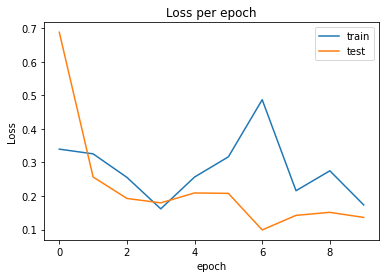

              precision    recall  f1-score   support

         bad       1.00      0.96      0.98        25
        good       0.98      1.00      0.99        46

    accuracy                           0.99        71
   macro avg       0.99      0.98      0.98        71
weighted avg       0.99      0.99      0.99        71



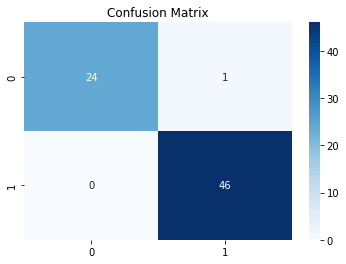

In [80]:
diagrams(training_losses,valid_losses,tr,X_test.values,y_test.values)